In [1]:
!pip install -q librosa

In [2]:
from dataclasses import dataclass
from pathlib import Path
from IPython.display import Audio, Image
from typing import Union

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torchaudio
from skimage.restoration import denoise_wavelet, estimate_sigma
from scipy.signal import butter, lfilter, freqz

In [6]:
ls /mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples

call-0/   call-17/  call-2/   call-28/  call-30/  call-35/  call-5/
call-1/   call-18/  call-25/  call-29/  call-33/  call-36/  call-6/
call-10/  call-19/  call-27/  call-3/   call-34/  call-4/   call-9/


In [8]:
WAV_DATA_PATH = Path('/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples')

# Load wav files that were extracted based on annotation provided by Locasio lab

In [83]:
calls = {}
total_calls = 0
for call_dir in sorted(WAV_DATA_PATH.glob('call-*')):
    if call_dir == 'call-0':
        continue
    
    call = int(call_dir.name.split('-')[-1])
    call_key = f'{call:02d}'
    dir_path = WAV_DATA_PATH / f'call-{call}' / 'clean'
    calls[call_key] = list(dir_path.glob('*.wav'))
    print(call_dir, len(calls[call_key]))
    total_calls += len(calls[call_key])

/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-0 0
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-1 698
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-10 259
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-17 809
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-18 888
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-19 1206
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-2 148
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-25 5161
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-27 5
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-28 0
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-29 0
/mnt/store/data/assets/black-grouper/data

In [84]:
total_calls

13052

In [85]:
calls.keys()

dict_keys(['00', '01', '10', '17', '18', '19', '02', '25', '27', '28', '29', '03', '30', '33', '34', '35', '36', '04', '05', '06', '09'])

In [86]:
# Summary of call types
for call_num in sorted(calls.keys()):
    try:
        y, sr = librosa.load(calls[call_num][0])
        print(f'Call type: {int(call_num):02d}, {len(calls[call_num]):04d} Recording Hz: {sr}')
    except IndexError:
        print(f'Call type: {int(call_num):02d}, 0000 calls')

Call type: 00, 0000 calls
Call type: 01, 0698 Recording Hz: 22050
Call type: 02, 0148 Recording Hz: 22050
Call type: 03, 1065 Recording Hz: 22050
Call type: 04, 0000 calls
Call type: 05, 0000 calls
Call type: 06, 0000 calls
Call type: 09, 2813 Recording Hz: 22050
Call type: 10, 0259 Recording Hz: 22050
Call type: 17, 0809 Recording Hz: 22050
Call type: 18, 0888 Recording Hz: 22050
Call type: 19, 1206 Recording Hz: 22050
Call type: 25, 5161 Recording Hz: 22050
Call type: 27, 0005 Recording Hz: 22050
Call type: 28, 0000 calls
Call type: 29, 0000 calls
Call type: 30, 0000 calls
Call type: 33, 0000 calls
Call type: 34, 0000 calls
Call type: 35, 0000 calls
Call type: 36, 0000 calls


In [87]:
for call_dir in sorted(WAV_DATA_PATH.glob('call-*')):
    wavs = list(call_dir.glob('**/*.wav'))
    print(f'{call_dir}: {len(wavs)}')

/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-0: 4057
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-1: 1227
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-10: 517
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-17: 919
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-18: 893
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-19: 1267
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-2: 243
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-25: 5165
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-27: 5
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-28: 1048
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-29: 0
/mnt/store/data/assets/

In [88]:
for call_dir in sorted(WAV_DATA_PATH.glob('call-*')):
    wavs = list(call_dir.glob('clean/*.wav'))
    print(f'{call_dir}: {len(wavs)}')

/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-0: 0
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-1: 698
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-10: 259
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-17: 809
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-18: 888
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-19: 1206
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-2: 148
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-25: 5161
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-27: 5
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-28: 0
/mnt/store/data/assets/black-grouper/data/training/wav/all-training-samples/call-29: 0
/mnt/store/data/assets/black-g

In [243]:
def load_wav(fpath):
    y, sr = librosa.load(fpath)
    audio, _ = librosa.effects.trim(y)
    
    return audio, sr

def plot_wav(fpath):
    audio = load_wav(fpath)
    
    plt.figure(figsize=(10, 8))
    librosa.display.waveshow(y=audio, sr=sr)
    
    plt.title(f'Sample {fpath}')

In [90]:
calls.keys()

dict_keys(['00', '01', '10', '17', '18', '19', '02', '25', '27', '28', '29', '03', '30', '33', '34', '35', '36', '04', '05', '06', '09'])

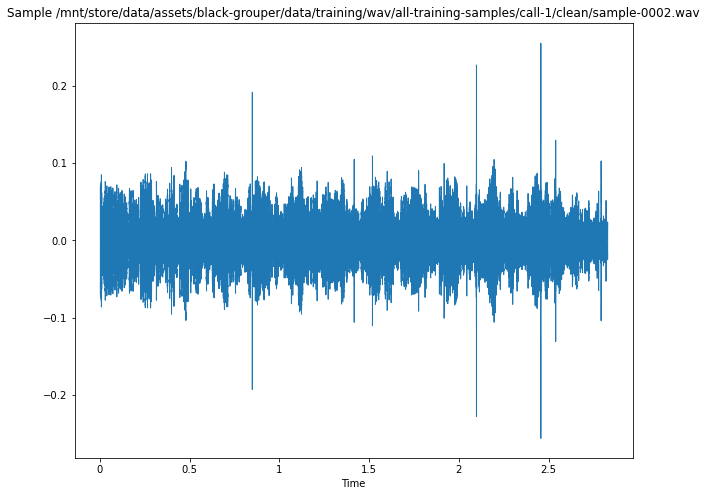

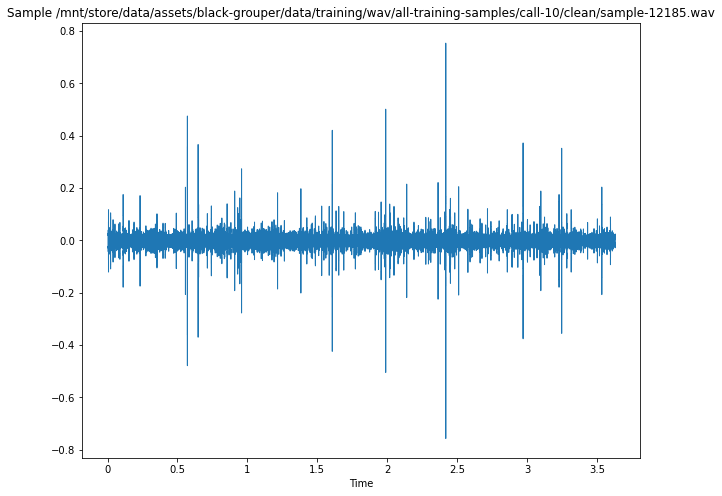

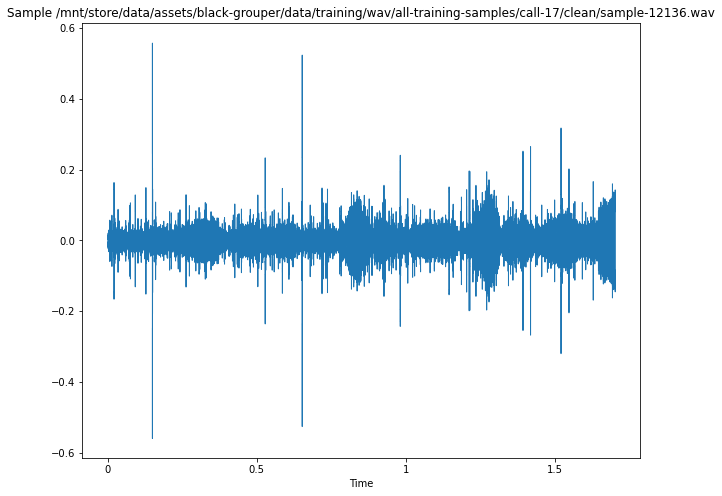

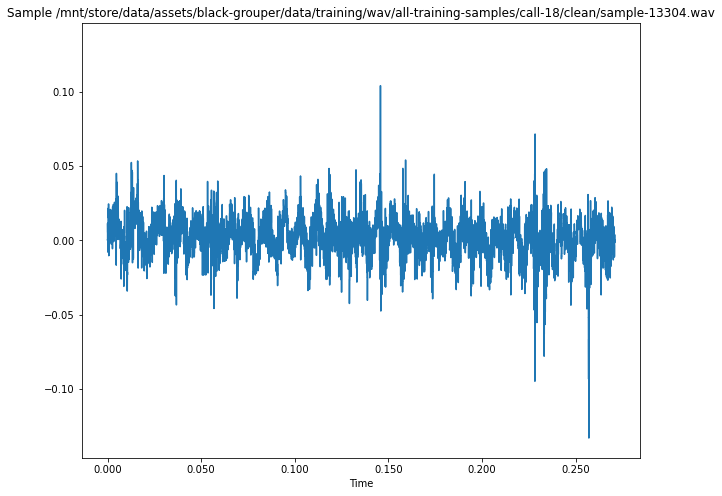

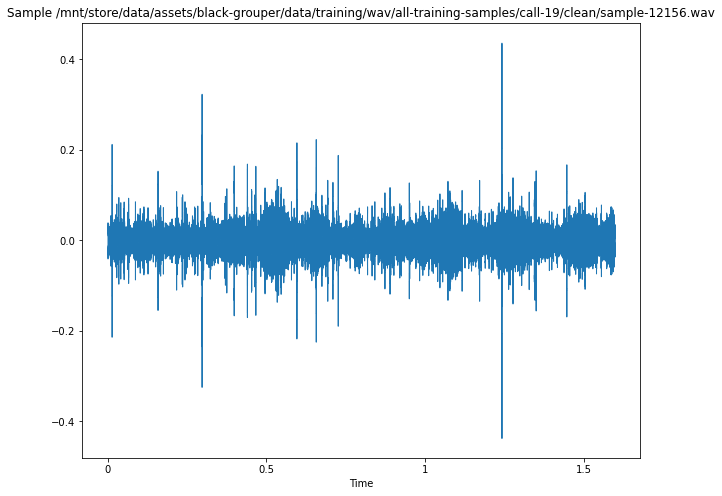

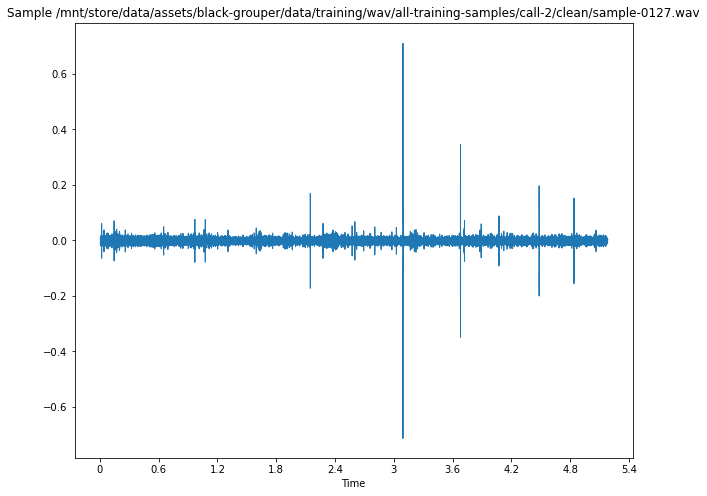

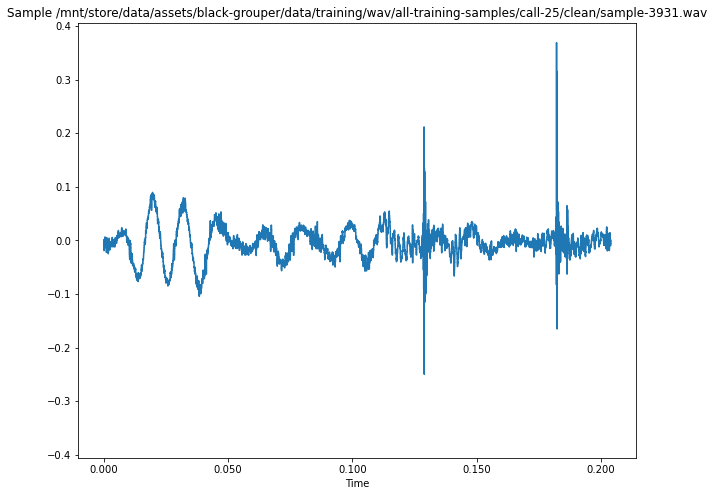

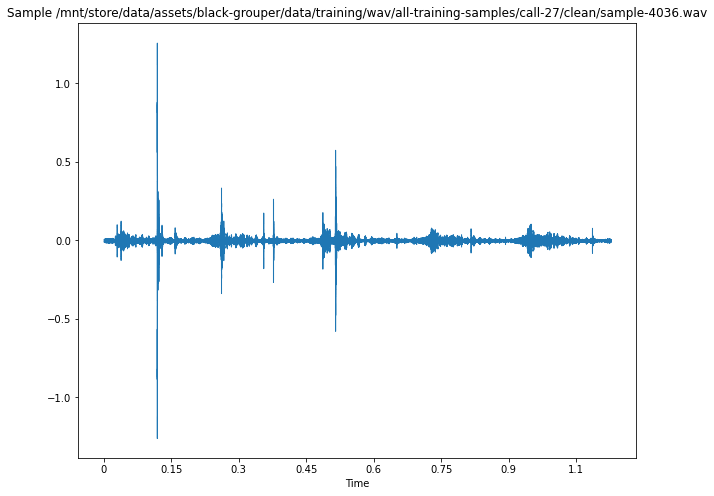

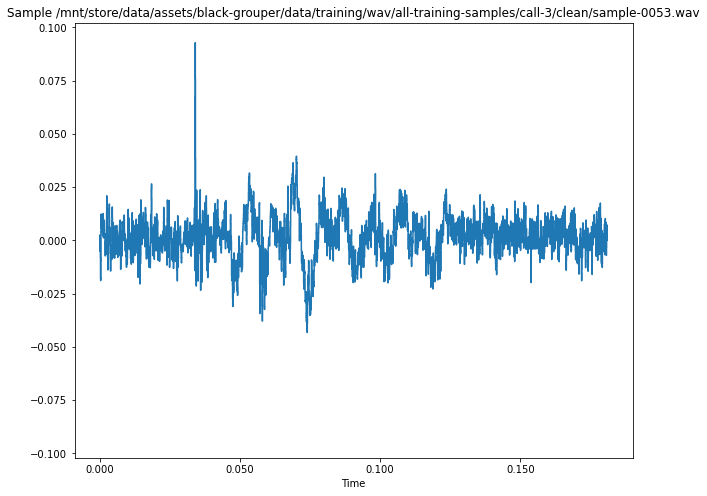

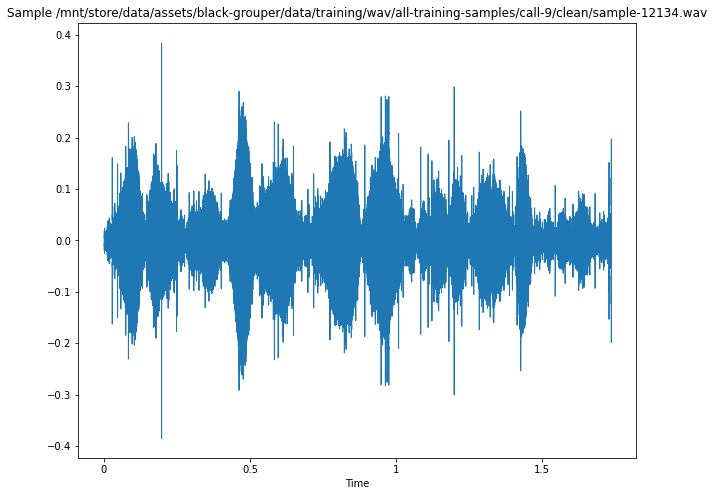

In [92]:
for call_num in calls.keys():
    try:
        plot_wav(calls[call_num][0])
    except:
        continue

## Dev spectrograms

In [187]:
@dataclass
class FFTConfig():
    n_fft: Union[int, None] = 1024
    hop_length: int = 512
    sr: int = 22_050
    db: bool = False
    mel: bool = False
    fmin: int = 50
    fmax: int = 10_000
    y_axis: str = 'linear'
    denoise: Union[str, None] = None
    pcen: bool = False
    cmap: str = 'gray_r'

In [188]:
base_config = FFTConfig()

In [189]:
def calc_stft(audio, fft_config):
    stft = librosa.stft(audio, n_fft=fft_config.n_fft, hop_length=fft_config.hop_length)
    return np.abs(stft)

In [190]:
calls.keys()

dict_keys(['00', '01', '10', '17', '18', '19', '02', '25', '27', '28', '29', '03', '30', '33', '34', '35', '36', '04', '05', '06', '09'])

In [191]:
wav_sample_01 = load_wav(calls['01'][1])

### Examine effect of hop length on freq rep

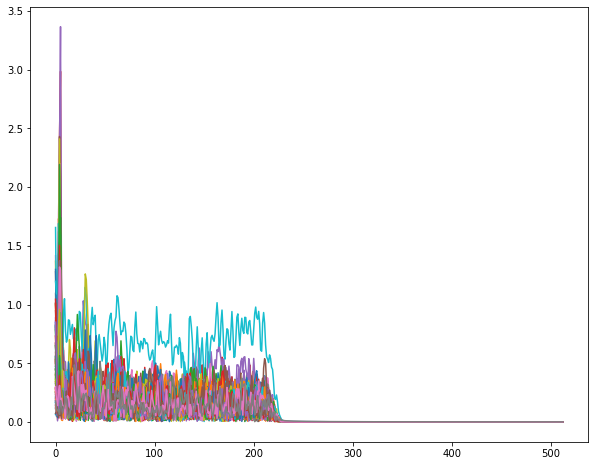

In [102]:
plt.figure(figsize=(10, 8))
plt.plot(calc_stft(wav_sample_01, base_config));

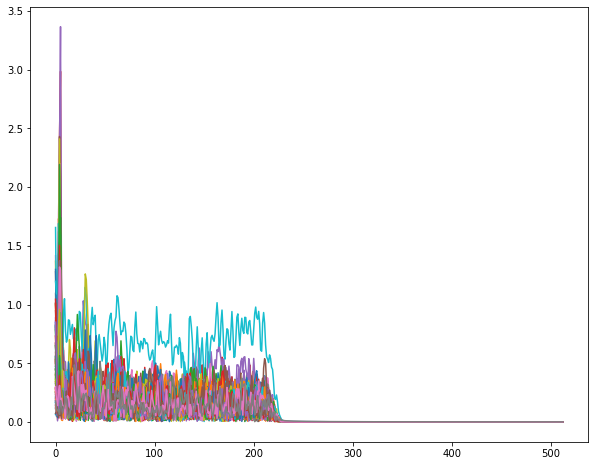

In [103]:
config = FFTConfig(1024, 512)
plt.figure(figsize=(10, 8))
plt.plot(calc_stft(wav_sample_01, config));

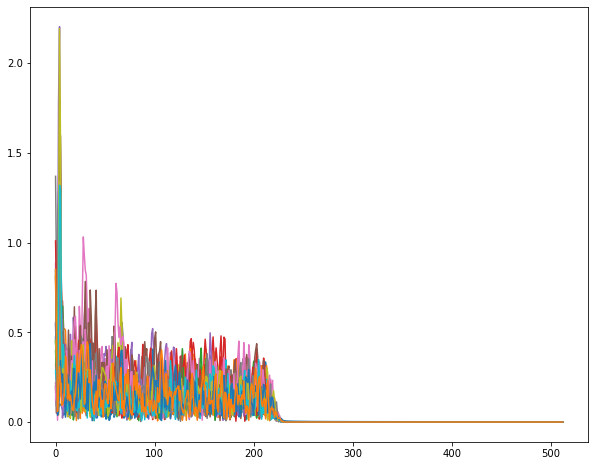

In [104]:
config = FFTConfig(1024, 2048)
plt.figure(figsize=(10, 8))
plt.plot(calc_stft(wav_sample_01, config));

### Examine number of FFTs on freq rep

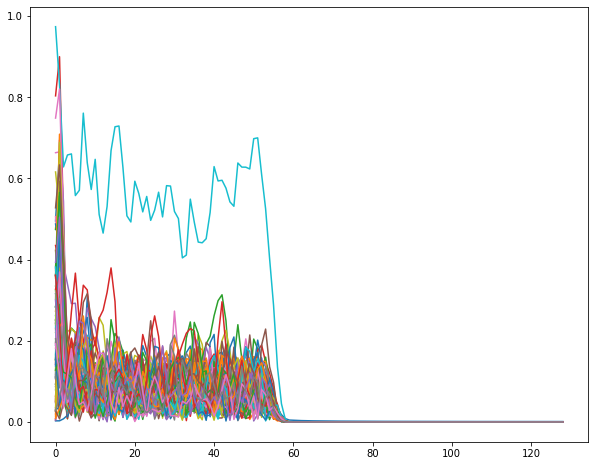

In [105]:
config = FFTConfig(256, 512)
plt.figure(figsize=(10, 8))
plt.plot(calc_stft(wav_sample_01, config));

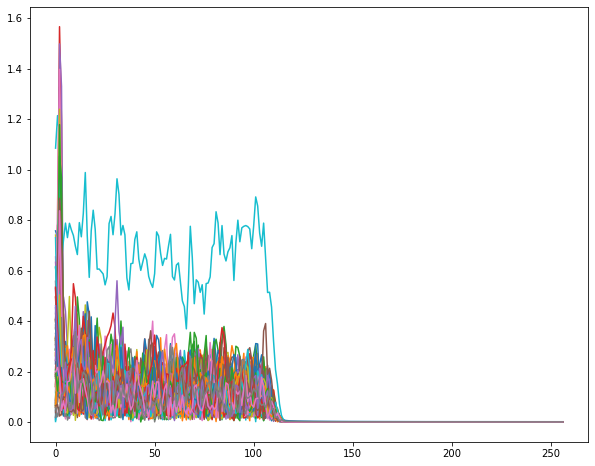

In [106]:
config = FFTConfig(512, 512)
plt.figure(figsize=(10, 8))
plt.plot(calc_stft(wav_sample_01, config));

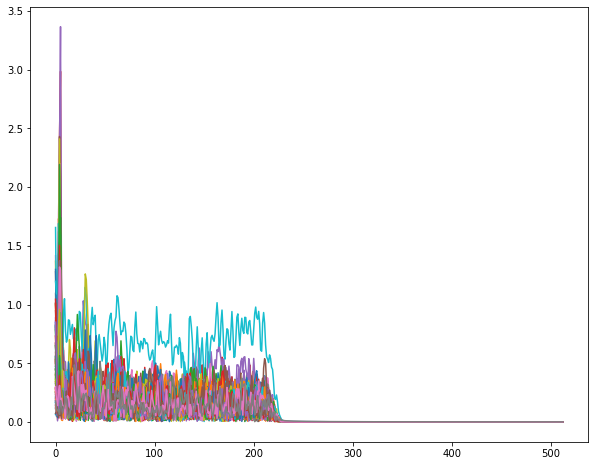

In [107]:
config = FFTConfig(1024, 512)
plt.figure(figsize=(10, 8))
plt.plot(calc_stft(wav_sample_01, config));

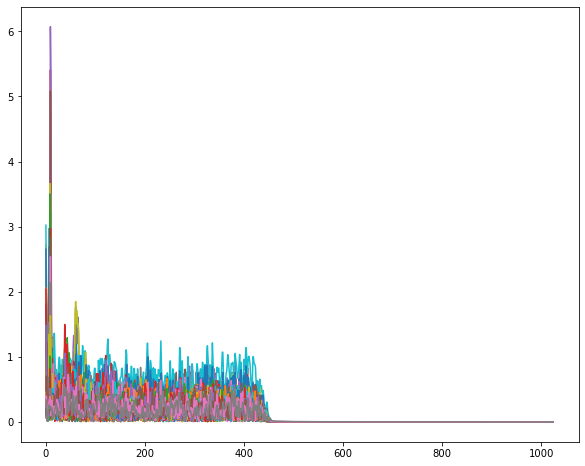

In [108]:
config = FFTConfig(2048, 512)
plt.figure(figsize=(10, 8))
plt.plot(calc_stft(wav_sample_01, config));

### Explore spectrograms

Compare:

    - db vs. linear
    - effects of hoplength + nffts
    - mel vs. "normal"

In [192]:
def plot_spec(audio, fft_config):
    breakpoint()
    stft = calc_stft(audio, fft_config)
    
    if fft_config.pcen:
        sftf = librosa.pcen(stft, sr=fft_config.sr, hop_length=fft_config.hop_length)
        fft_config.db = True
    
    if fft_config.mel:
        stft = librosa.feature.melspectrogram(y=audio, sr=fft_config.sr)
        # Mel is in db
        fft_config.db = True
    
    if fft_config.db:
        stft = librosa.amplitude_to_db(stft, ref=np.max)
        
    fig, ax = plt.subplots(figsize=(10, 8))
    print(stft.shape)
    img = librosa.display.specshow(
        stft,
        sr=fft_config.sr,
        hop_length=fft_config.hop_length,
        x_axis='time',
        y_axis=fft_config.y_axis,
        fmin=fft_config.fmin,
        fmax=fft_config.fmax,
        cmap=fft_config.cmap,
        ax=ax
    )
    plt.title(f'{fft_config}')
    return fig, img, ax

(513, 88)


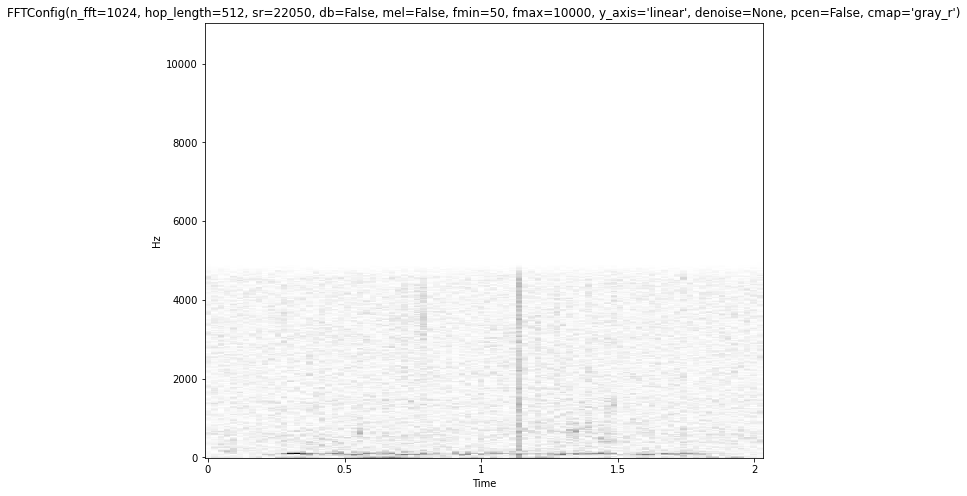

In [193]:
_ = plot_spec(wav_sample_01, base_config)

(128, 88)


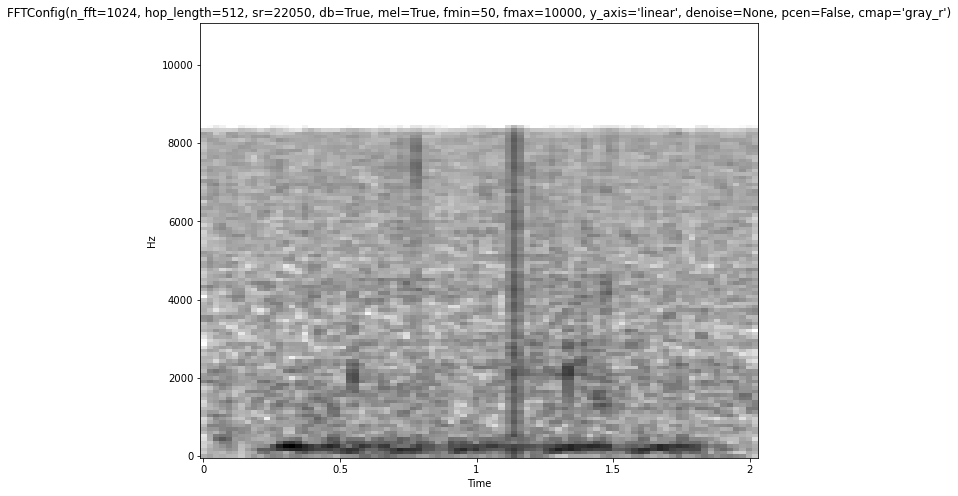

In [194]:
config = FFTConfig(
    mel=True
)
_ = plot_spec(wav_sample_01, config)

(128, 88)


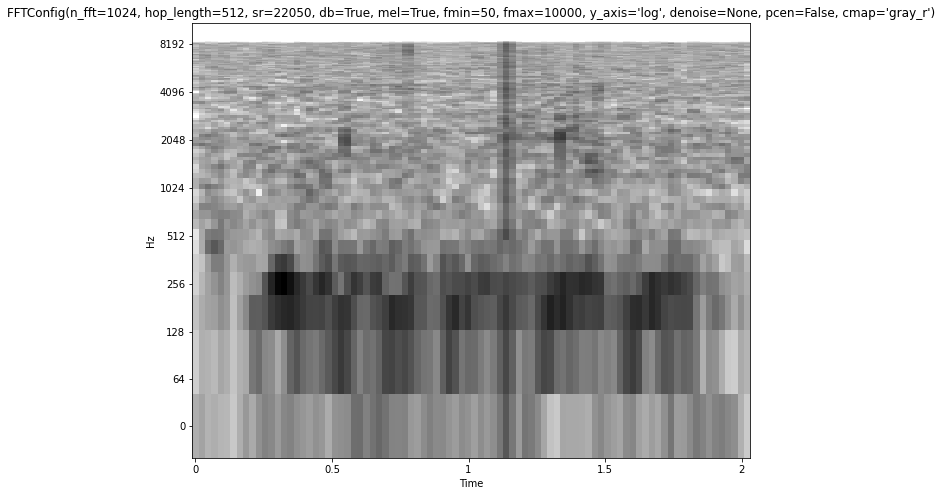

In [195]:
config = FFTConfig(
    mel=True,
    y_axis='log'
)
_ = plot_spec(wav_sample_01, config)

FFTConfig(n_fft=1024, hop_length=512, sr=22050, db=False, mel=True, fmin=50, fmax=10000, y_axis='linear', denoise=None, pcen=False, cmap='gray_r')
(128, 88)


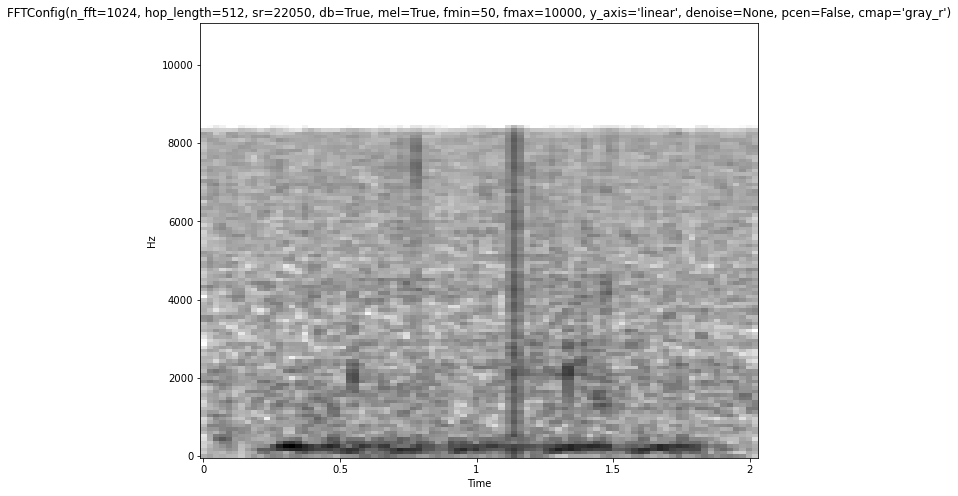

In [196]:
config = FFTConfig(
    mel=True,
)
print(config)
_ = plot_spec(wav_sample_01, config)

FFTConfig(n_fft=256, hop_length=512, sr=22050, db=False, mel=True, fmin=50, fmax=10000, y_axis='linear', denoise=None, pcen=False, cmap='gray_r')
(128, 88)


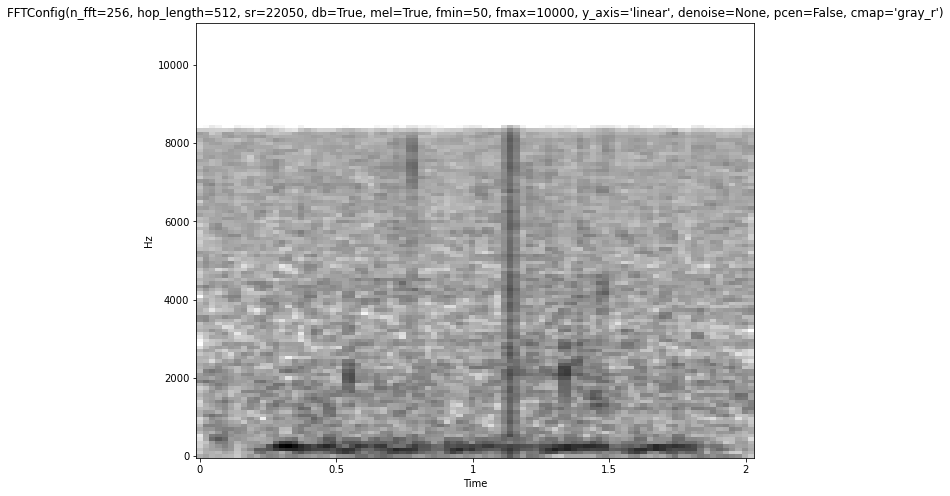

In [197]:
config = FFTConfig(
    n_fft=256,
    mel=True,
    hop_length=512,
)
print(config)
_ = plot_spec(wav_sample_01, config)

(128, 88)


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':"FFTConfig(n_fft=512, hop_length=512, sr=22050, db=True, mel=True, fmin=50, fmax=10000, y_axis='linear', denoise=None, pcen=False, cmap='gray_r')"}, xlabel='Time', ylabel='Hz'>)

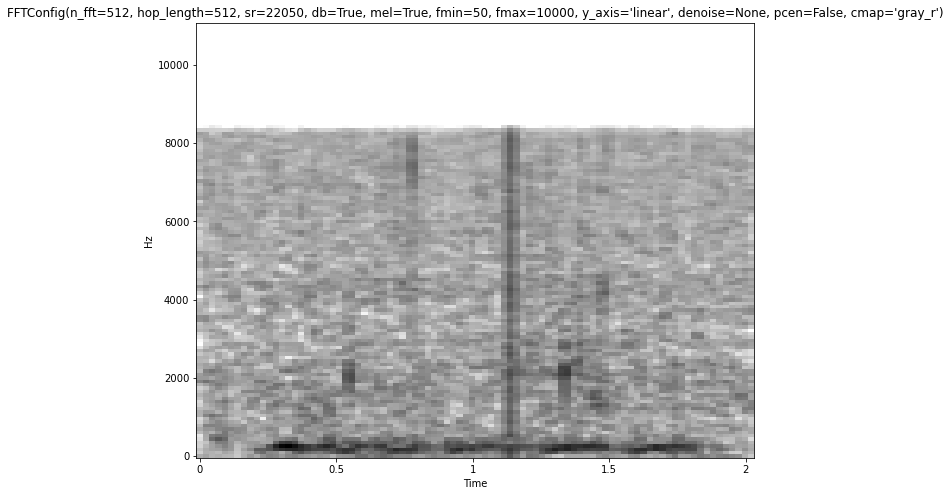

In [198]:
config = FFTConfig(
    n_fft=512,
    mel=True,
    hop_length=512,
)
plot_spec(wav_sample_01, config)

(128, 88)


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':"FFTConfig(n_fft=1024, hop_length=512, sr=22050, db=True, mel=True, fmin=50, fmax=10000, y_axis='linear', denoise=None, pcen=False, cmap='gray_r')"}, xlabel='Time', ylabel='Hz'>)

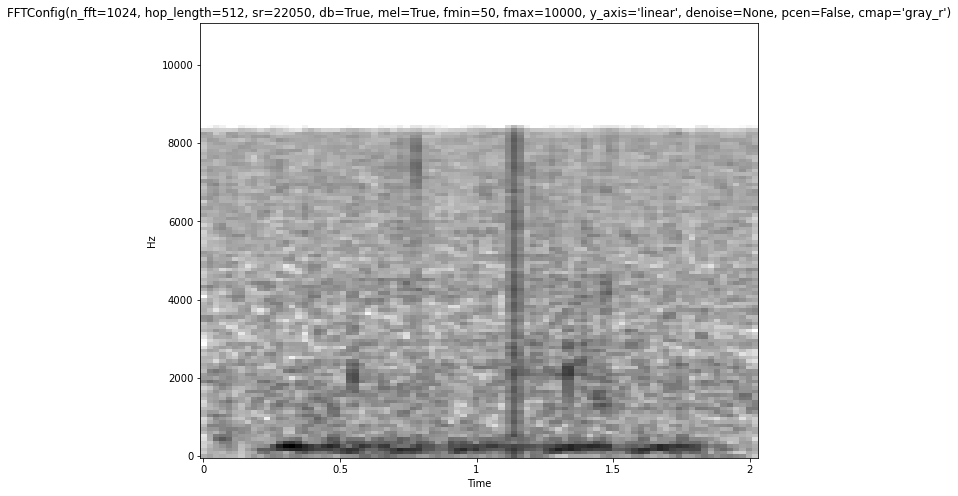

In [199]:
config = FFTConfig(
    n_fft=1024,
    mel=True,
    hop_length=512,
)
plot_spec(wav_sample_01, config)

(128, 88)


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':"FFTConfig(n_fft=2048, hop_length=512, sr=22050, db=True, mel=True, fmin=50, fmax=10000, y_axis='linear', denoise=None, pcen=False, cmap='gray_r')"}, xlabel='Time', ylabel='Hz'>)

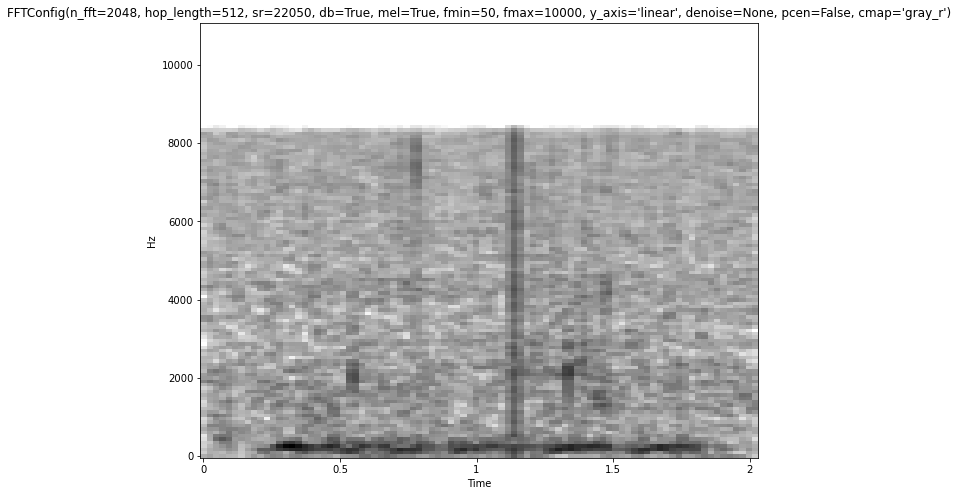

In [200]:
config = FFTConfig(
    n_fft=2048,
    mel=True,
    hop_length=512,
)
plot_spec(wav_sample_01, config)

(128, 88)


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':"FFTConfig(n_fft=32768, hop_length=512, sr=22050, db=True, mel=True, fmin=50, fmax=10000, y_axis='linear', denoise=None, pcen=False, cmap='gray_r')"}, xlabel='Time', ylabel='Hz'>)

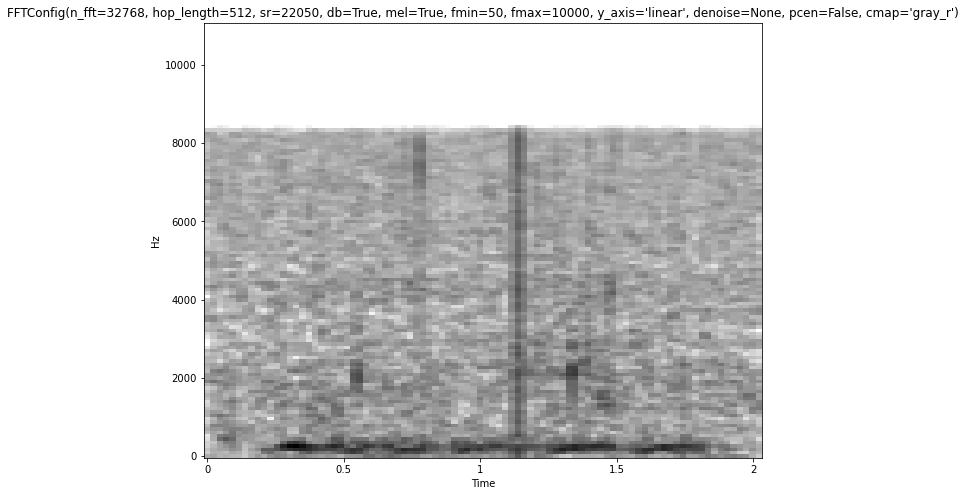

In [201]:
config = FFTConfig(
    n_fft=2**15,
    mel=True,
    hop_length=512,
)
plot_spec(wav_sample_01, config)

(2049, 88)


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':"FFTConfig(n_fft=4096, hop_length=512, sr=22050, db=False, mel=False, fmin=50, fmax=10000, y_axis='log', denoise=None, pcen=False, cmap='gray_r')"}, xlabel='Time', ylabel='Hz'>)

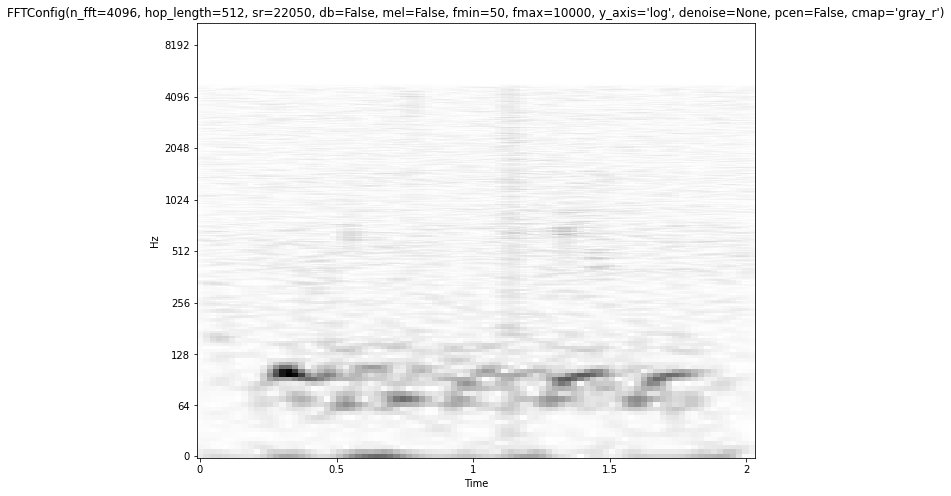

In [202]:
config = FFTConfig(
    n_fft=2**12,
    mel=False,
    hop_length=512,
    y_axis='log'
)
plot_spec(wav_sample_01, config)

(2049, 88)


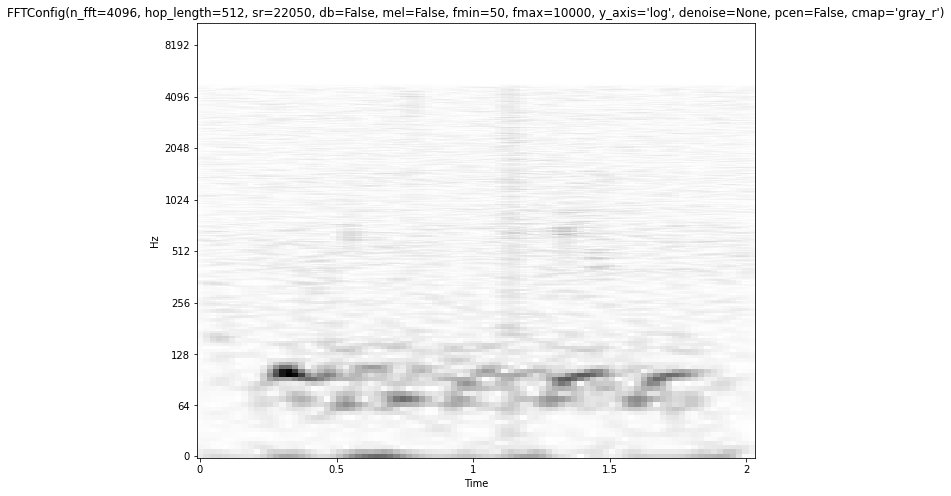

In [203]:
config = FFTConfig(
    n_fft=2**12,
    mel=False,
    y_axis='log',
)
fig, img, ax = plot_spec(wav_sample_01, config)

(2049, 893)


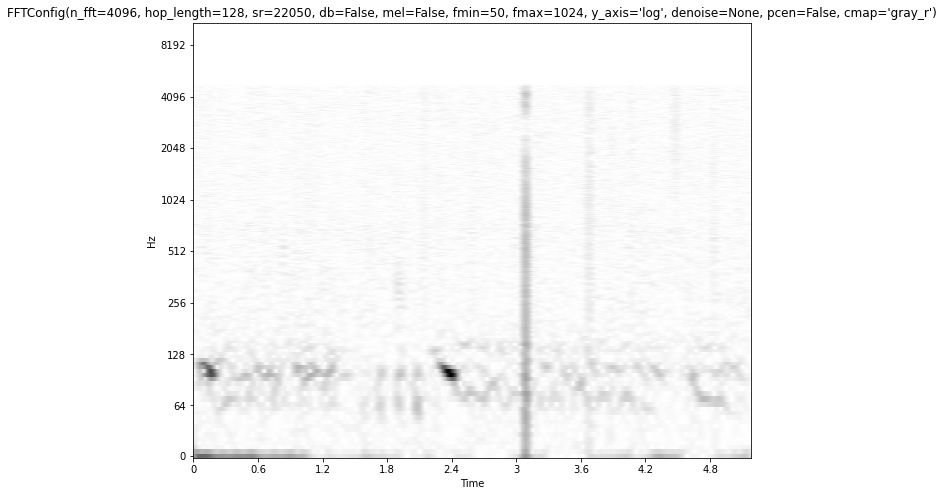

In [233]:
wav_sample_02 = load_wav(calls['02'][0])
config = FFTConfig(
    n_fft=2**12,
    mel=False,
    hop_length=128,
    y_axis='log',
    fmin=50,
    fmax=1024
)
_ = plot_spec(wav_sample_02, config)

(2049, 480)


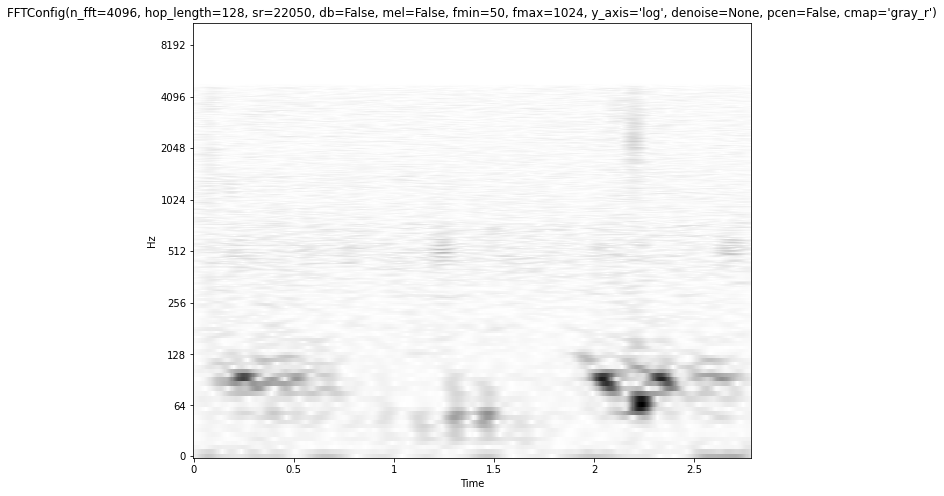

In [234]:
wav_sample_02 = load_wav(calls['02'][1])
config = FFTConfig(
    n_fft=2**12,
    mel=False,
    hop_length=128,
    y_axis='log',
    fmin=50,
    fmax=1024
)
_ = plot_spec(wav_sample_02, config)

(2049, 712)


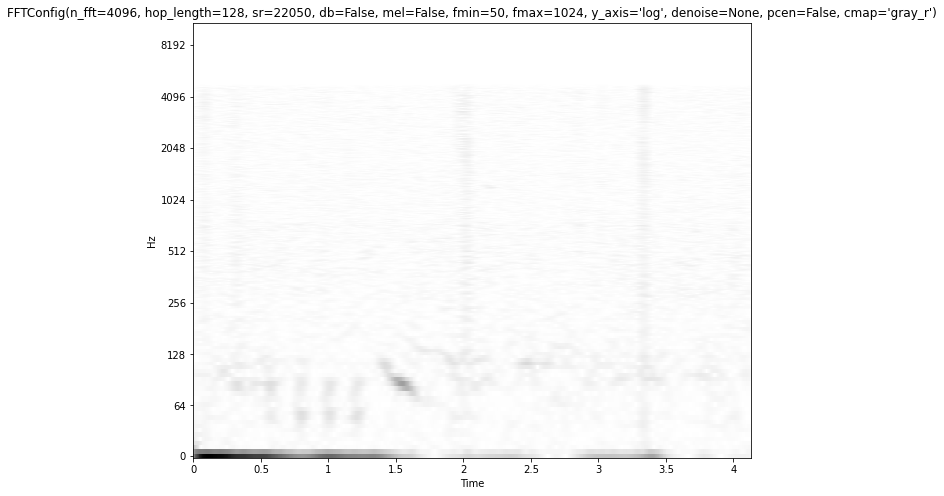

In [235]:
wav_sample_02 = load_wav(calls['02'][2])
config = FFTConfig(
    n_fft=2**12,
    mel=False,
    hop_length=128,
    y_axis='log',
    fmin=50,
    fmax=1024
)
_ = plot_spec(wav_sample_02, config)

(2049, 650)


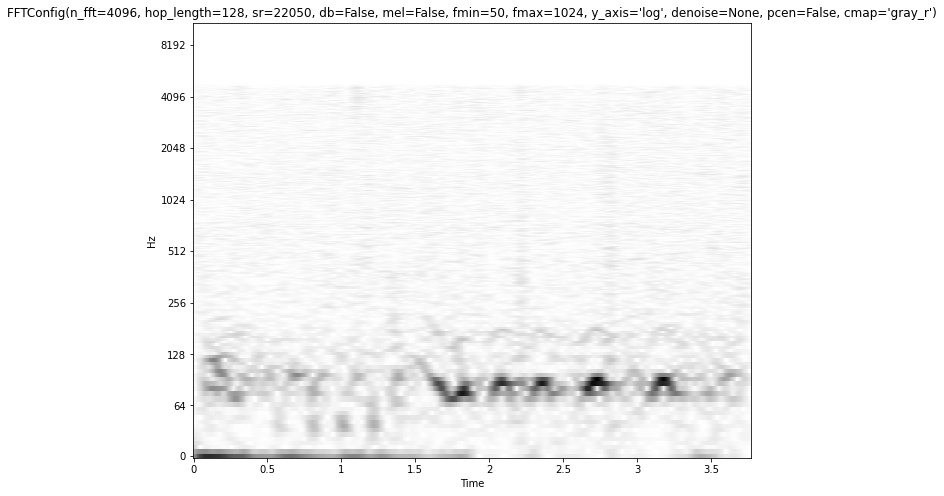

In [236]:
wav_sample_02 = load_wav(calls['02'][3])
config = FFTConfig(
    n_fft=2**12,
    mel=False,
    hop_length=128,
    y_axis='log',
    fmin=50,
    fmax=1024
)
_ = plot_spec(wav_sample_02, config)

(2049, 260)


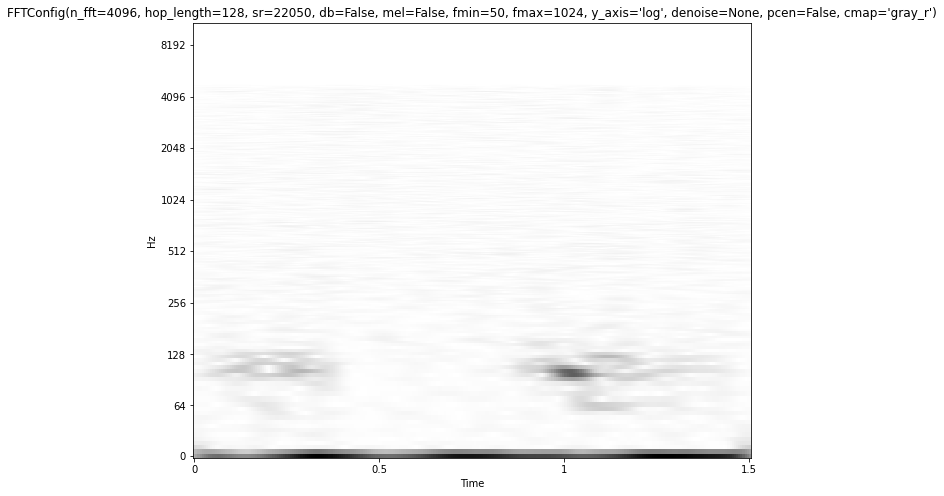

In [237]:
wav_sample_02 = load_wav(calls['02'][4])
config = FFTConfig(
    n_fft=2**12,
    mel=False,
    hop_length=128,
    y_axis='log',
    fmin=50,
    fmax=1024
)
_ = plot_spec(wav_sample_02, config)

(2049, 84)


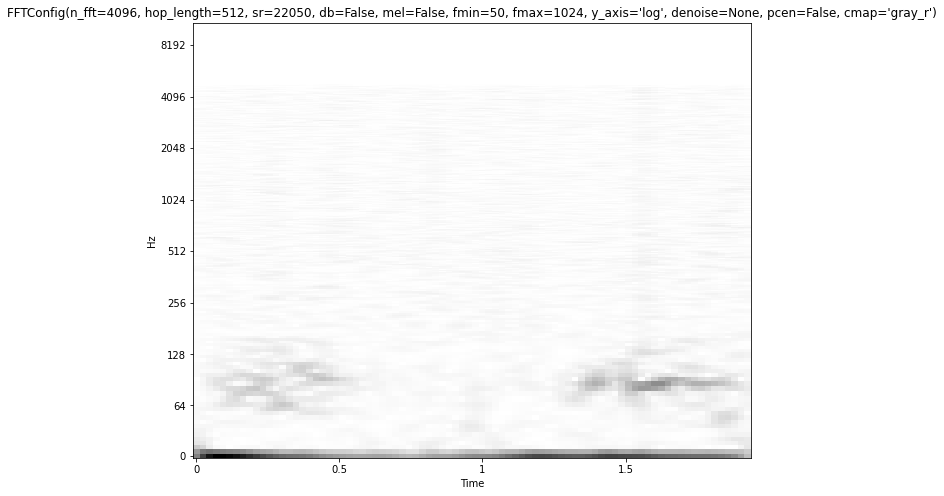

In [242]:
wav_sample_02 = load_wav(calls['02'][5])
config = FFTConfig(
    n_fft=2**12,
    mel=False,
    hop_length=512,
    y_axis='log',
    fmin=50,
    fmax=1024
)
_ = plot_spec(wav_sample_02, config)

(2049, 34)


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':"FFTConfig(n_fft=4096, hop_length=128, sr=22050, db=False, mel=False, fmin=50, fmax=1024, y_axis='log', denoise=None, pcen=False, cmap='gray_r')"}, xlabel='Time', ylabel='Hz'>)

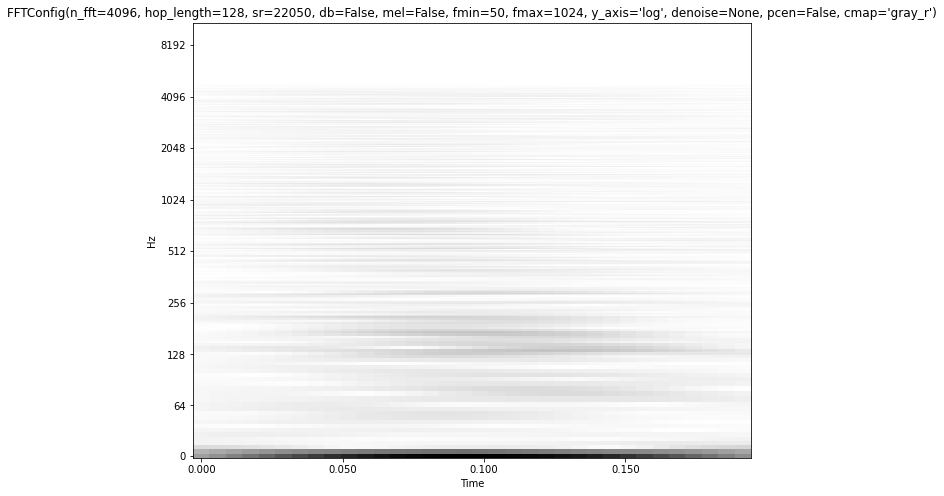

In [231]:
config = FFTConfig(
    n_fft=2**12,
    mel=False,
    hop_length=128,
    y_axis='log',
    fmin=50,
    fmax=1024
)
plot_spec(wav_sample_03, config)

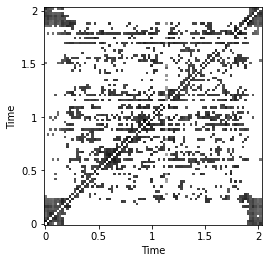

In [220]:
C = librosa.cqt(y=wav_sample_01, sr=22_050)
C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)
R = librosa.segment.recurrence_matrix(C_db, mode='affinity')
fig, ax = plt.subplots()
img = librosa.display.specshow(R, y_axis='time', x_axis='time', ax=ax, cmap='gray_r')

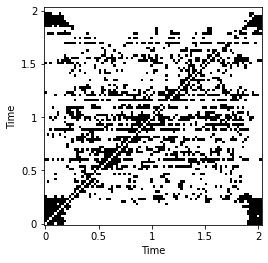

In [222]:
C = librosa.cqt(y=wav_sample_01, sr=22_050)
C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)
R = librosa.segment.recurrence_matrix(C_db, mode='connectivity')
fig, ax = plt.subplots()
img = librosa.display.specshow(R, y_axis='time', x_axis='time', ax=ax, cmap='gray_r')

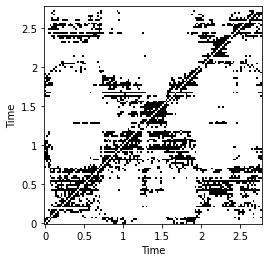

In [223]:
wav_sample_02 = load_wav(calls['02'][1])
C = librosa.cqt(y=wav_sample_02, sr=22_050)
C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)
R = librosa.segment.recurrence_matrix(C_db, mode='connectivity')
fig, ax = plt.subplots()
img = librosa.display.specshow(R, y_axis='time', x_axis='time', ax=ax, cmap='gray_r')

/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=256 is too small for input signal of length=136
  return f(*args, **kwargs)
/opt/conda/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=256 is too small for input signal of length=68
  return f(*args, **kwargs)


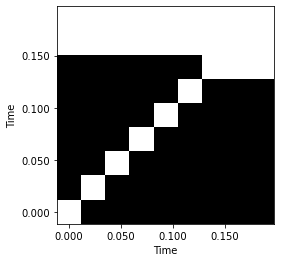

In [229]:
wav_sample_03 = load_wav(calls['03'][10])
C = librosa.cqt(y=wav_sample_03, sr=22_050)
C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)
R = librosa.segment.recurrence_matrix(C_db, mode='connectivity')
fig, ax = plt.subplots()
img = librosa.display.specshow(R, y_axis='time', x_axis='time', ax=ax, cmap='gray_r')

(513, 88)


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':"FFTConfig(n_fft=1024, hop_length=512, sr=22050, db=True, mel=False, fmin=50, fmax=10000, y_axis='log', denoise=None, pcen=True, cmap='gray_r')"}, xlabel='Time', ylabel='Hz'>)

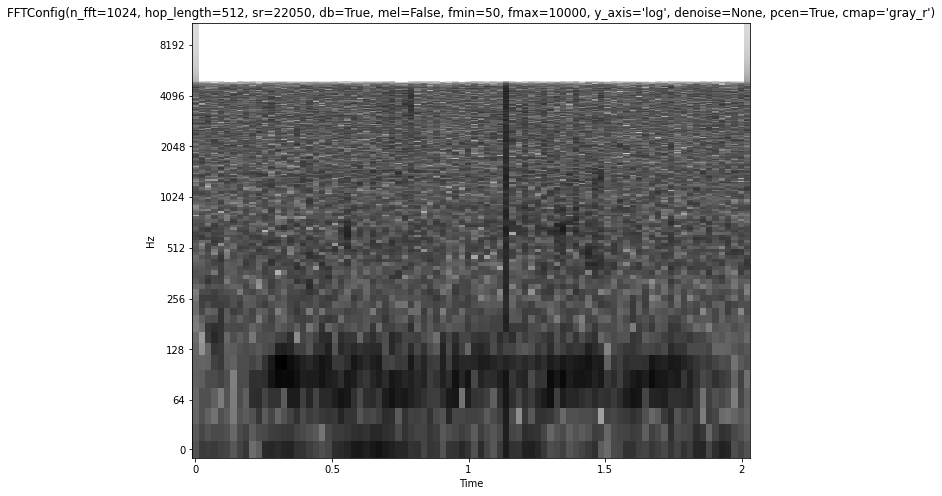

In [205]:
config = FFTConfig(
    n_fft=1024,
    mel=False,
    hop_length=512,
    y_axis='log',
    pcen=True
)
plot_spec(wav_sample_01, config)

(128, 88)


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':"FFTConfig(n_fft=1024, hop_length=512, sr=22050, db=True, mel=True, fmin=50, fmax=10000, y_axis='log', denoise=None, pcen=True, cmap='gray_r')"}, xlabel='Time', ylabel='Hz'>)

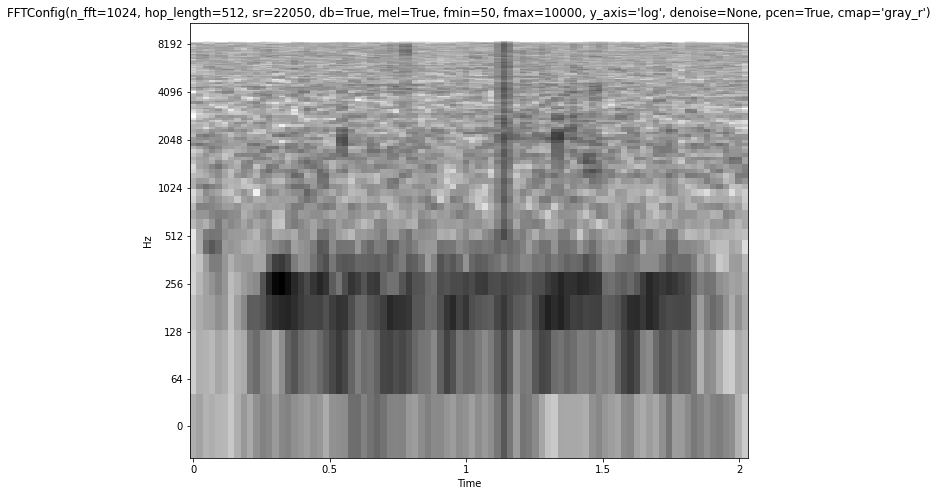

In [206]:
config = FFTConfig(
    n_fft=1024,
    mel=True,
    hop_length=512,
    y_axis='log',
    pcen=True
)
plot_spec(wav_sample_01, config)

In [123]:
Audio(wav_sample_01, rate=22_050)

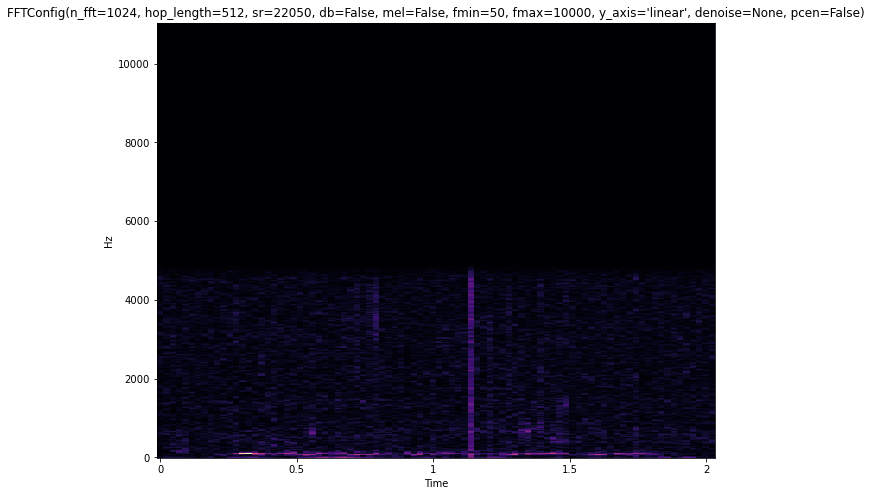

In [124]:
plot_spec(wav_sample_01, base_config)

### Idea.

Turn creation of spectrograms into an optimization problem where the distance
between clusters is maximized.